### Predicting Credit Risk
#### ADS 505 | Team 4 | Trevor Sauerbrey, Logan Van Dine, Vicky van der Wagt

https://github.com/trevsauer/Predicting_Credit_Risk.git

In [1]:
# Import required packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import warnings
import time

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

## Business Problem and Proposed Solution

The German Banking Company has found that the current process for determining whether a consumer is a good or bad candidate for credit is time consuming, expensive, and inconsistent. The choice of accepting or denying a consumer's request for a credit line can greatly affect the path of the company's revenue and future. Currently, a manual review process is in place that requires employees to scour through credit applications daily. An employee's time is costly and often times, not efficient enough for the influx of consumers.

The German Banking Company would like to introduce a technical solution that will drive efficiency while also being effective. Our team has worked through multiple classification models to determine what we feel will be a best fit based on the criteria provided. The German Banking Company has specifically requested that our main objective be to reduce time, cut costs, and ensure that the technical solution is correctly classifying consumers as good or bad credit.

In [2]:
# df = pd.read_csv(os.path.join(os.getcwd(), 'german_credit_data.csv'))
df = pd.read_csv(r"C:\MIDS\ADS_505_Applied_Data_Science_for_Business\ADS-505_Final_Project_Team_4\data\german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


The data set includes  10 features, 9 of which are predictors and one target feature: Risk.

### Feature Creation

In [3]:
# Create categorical feature for age
interval = (18, 25, 35, 60, 120)
# (18, 25) represents the interval for "Students" (ages 18 to 25).
# (25, 35) represents the interval for "Young adults" (ages 26 to 35).
# (35, 60) represents the interval for "Adults" (ages 36 to 60).
# (60, 120) represents the interval for "Seniors" (ages 61 to 120).
cats = ['Student', 'Young Adult', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

Above, we are creating a new feature, "Age_cat", that will transform the original age variable into a categorical value of either Students, Young Adults, Adults, or Seniors. This is beneficial to model building and stakeholders as it gives a more specific idea of consumer demographics and better organizes what was a widespread range in the variable.

## Exploratory Data Analysis

### Summary Statistics

In [4]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the dataset and store the summary
summary = analyze_data(df)
summary

Dataset Shape: (1000, 11)


,Name,dtypes,Missing,Uniques,First Value,Entropy,Skewness,Kurtosis,Min,Mean,Median,Max,Std,Outliers
0,Age,int64,0,53,67,5.27,1.02,0.59,19.0,35.546,33.0,75.0,11.375469,23.0
1,Sex,object,0,2,male,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Job,int64,0,4,2,1.41,-0.37,0.49,0.0,1.904,2.0,3.0,0.653614,370.0
3,Housing,object,0,3,own,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saving accounts,object,183,4,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Checking account,object,394,3,little,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Credit amount,int64,0,921,1169,9.80,1.95,4.27,250.0,3271.258,2319.5,18424.0,2822.736876,72.0
7,Duration,int64,0,33,6,3.76,1.09,0.91,4.0,20.903,18.0,72.0,12.058814,70.0
8,Purpose,object,0,8,radio/TV,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Risk,object,0,2,good,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The summary statistics of the data set provide initial insight to the distribution of the data. As many of the variables are categorical, many statistical values return NaN. However, a statistical value that sticks out in the above table is the missing values in the checking and savings accounts. It is also important to note that of the numeric features, the means are vastly different, suggesting that standardization will be necessary for model building.

#### Target Variable Distribution 

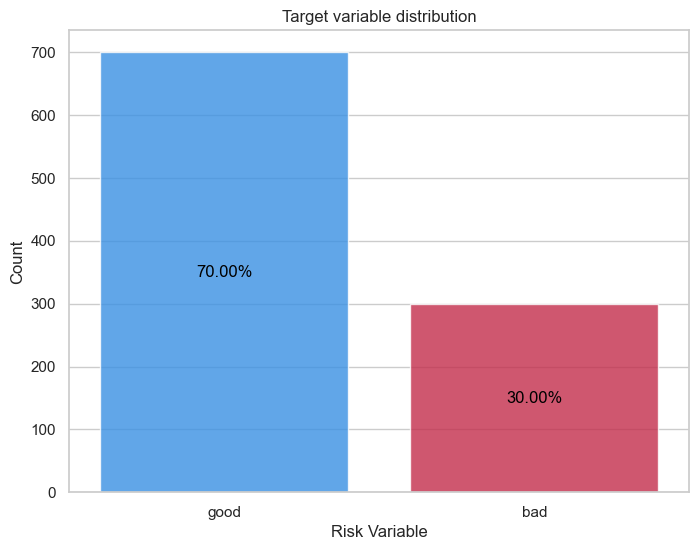

In [5]:
# Calculate the counts for 'good' and 'bad' credit
counts = df['Risk'].value_counts()

# Calculate the percentages
total_count = counts.sum()
percentages = (counts / total_count) * 100

# Create a bar chart with percentages in the center of each bar using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=counts.index, y=counts.values, palette=['dodgerblue', 'crimson'], alpha=0.8)
plt.xlabel('Risk Variable')
plt.ylabel('Count')
plt.title('Target variable distribution')

# Add percentages at the center of each bar
for bar, percentage in zip(ax.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.2f}%', 
             ha='center', va='center', fontsize=12, color='black')

plt.show()

There is a class imbalance in the target variable, risk, that will have to be corrected in data preprocessing by resampling the data. An imbalance of this magnitude will train the model incorrectly, causing a bias towards a "good" credit classification.

#### Distribution of Numerical Features vs Target

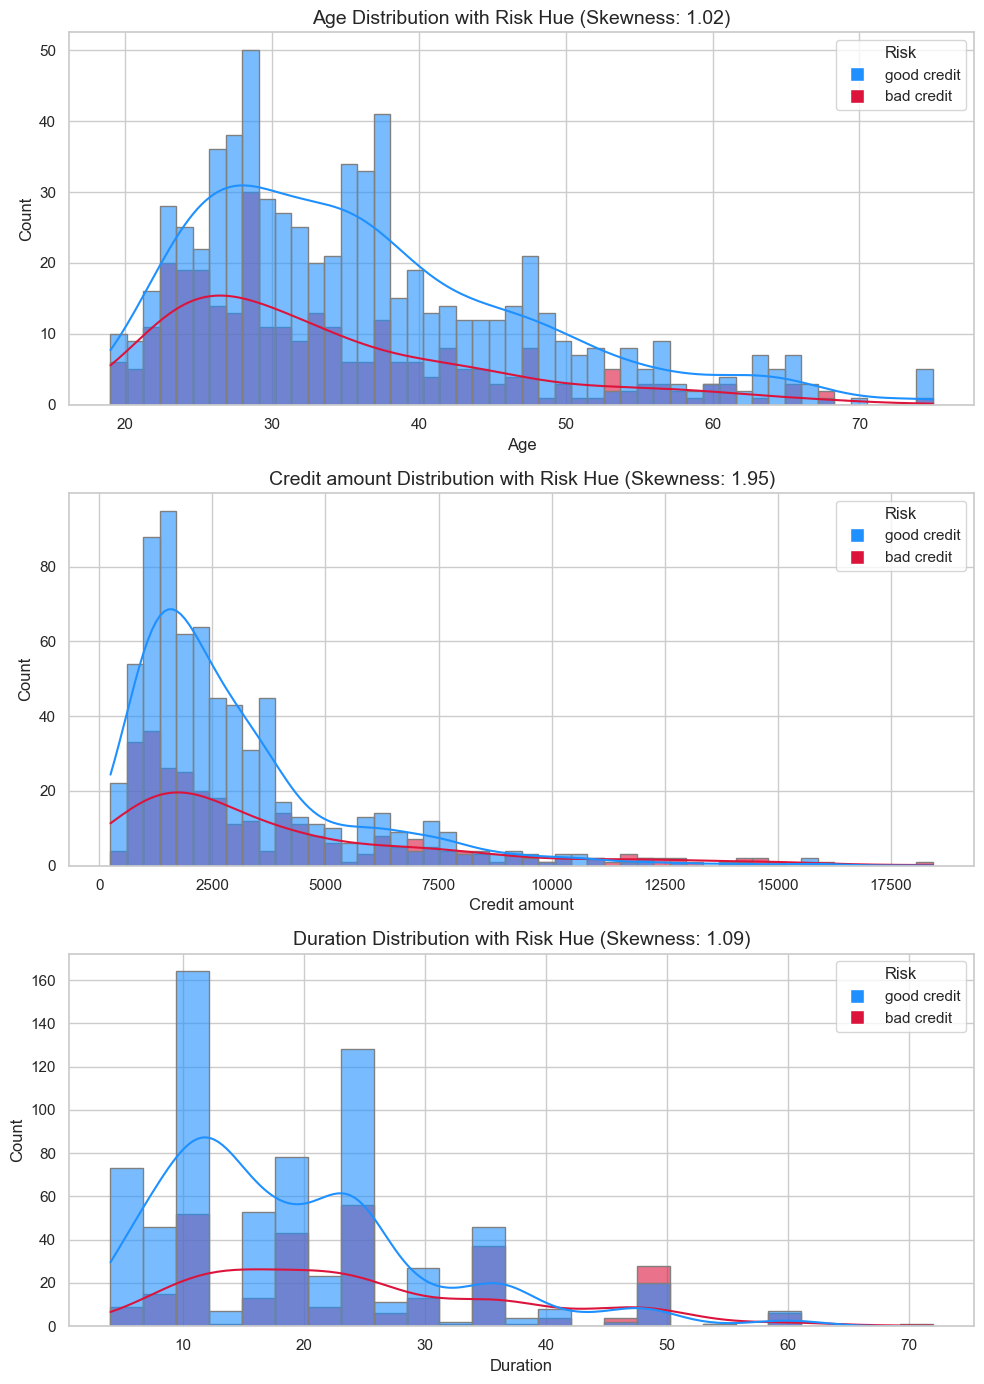

In [6]:
# Create a 3x1 grid of histograms with different bin counts
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Columns to plot and their corresponding bin counts
columns_to_plot = ['Age', 'Credit amount', 'Duration']
bin_counts = [50, 50, 25]  # Adjust the bin counts as needed

# Loop through columns and create histograms with specified bin counts
for i, (column, bins) in enumerate(zip(columns_to_plot, bin_counts)):
    ax = axes[i]
    
    # Calculate skewness
    skewness = df[column].skew()
    
    sns.histplot(data=df, x=column, hue='Risk', alpha=0.6, element='bars', bins=bins, 
                 palette={'good': 'dodgerblue', 'bad': 'crimson'}, edgecolor='grey', kde=True, legend=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Add skewness to the title
    ax.set_title(f'{column} Distribution with Risk Hue (Skewness: {skewness:.2f})', fontsize=14)
    sns.set(style="whitegrid")
    legend_labels = ['good credit', 'bad credit']
    legend_colors = ['dodgerblue', 'crimson']
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, title='Risk')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

The imbalance of the target variable is seen again in the above histograms of numeric features versus the target feature. Each numeric feature records a higher count of "good" credit records. The above histograms are noticeabley right-skewed and therfor a positive skewness. The skew of the above histograms suggests that outliers in the dataset will fall in the larger numeric feature records. An initial check of outliers is created below with the original dataset in the form of box-and-whisker plots.

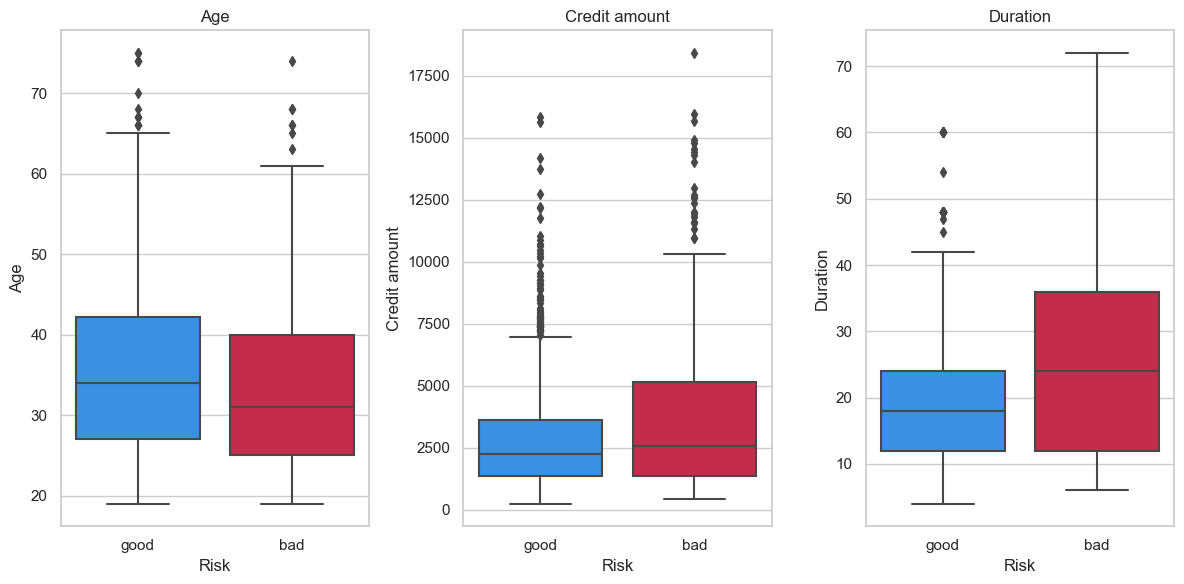

In [7]:
# Sample data frame 'df' and custom_palette defined earlier
sns.set(style="whitegrid")

custom_palette = {'good': 'dodgerblue', 'bad': 'crimson'}
plt.figure(figsize=(12, 6)) 

# Create separate boxplots for 'good' and 'bad' categories
plt.subplot(1, 3, 1)
sns.boxplot(x='Risk', y='Age', data=df, palette=custom_palette)
plt.title('Age')

plt.subplot(1, 3, 2)
sns.boxplot(x='Risk', y='Credit amount', data=df, palette=custom_palette)
plt.title('Credit amount')

plt.subplot(1, 3, 3)
sns.boxplot(x='Risk', y='Duration', data=df, palette=custom_palette)
plt.title('Duration')

plt.tight_layout()
plt.show()

The box-and-whisker plots above do confirm outliers present in the data. The second quartile of each plot in both "good" and "bad" credit risk suggest that the middle of the data is within the lower values of the feautres, further validating a positive skew of the numeric variables. To determine if outliers need to be transformed, removed, or left as is, we have moved to define the outliers based on z-scores below. Age is not included in the the z-score outlier detection for two reasons. First, we have created age categories that better summarize the widespread range of the ages. Second, it is highly likely that consumers could be in the higher age range of 70+, there are no data points in the age category that are not realistic.

#### Outlier Detection with Z-scores (Threshold = 3)

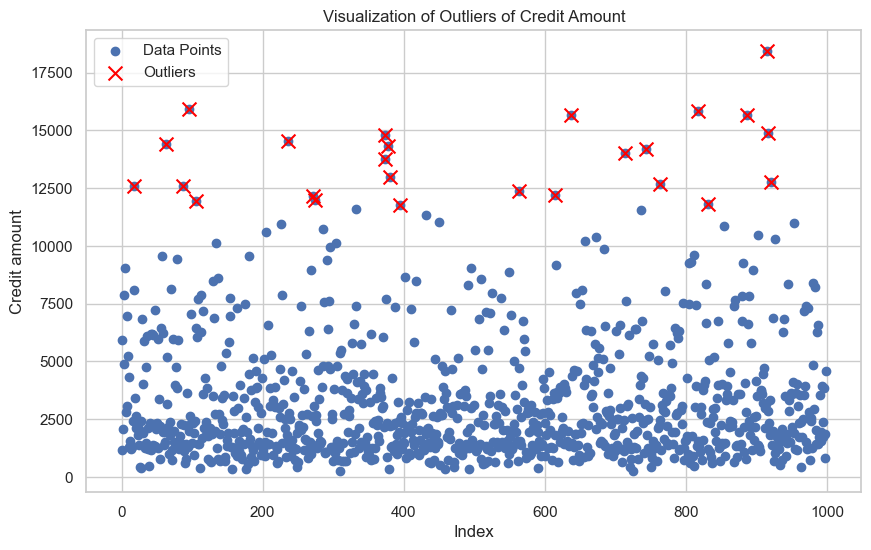

In [8]:
# Credit Amount
# Outliers of Numeric Variables
z_scores = stats.zscore(df['Credit amount'])
threshold = 3
outliers = np.where(np.abs(z_scores) > threshold)

outlier_indices = np.where(np.abs(z_scores) > threshold)
outlier_values = df['Credit amount'].iloc[outlier_indices]

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Credit amount'], label='Data Points')

# Highlight the outliers
plt.scatter(outlier_indices, outlier_values, color='red', label='Outliers', marker='x', s=100)

plt.xlabel('Index')
plt.ylabel('Credit amount')
plt.title('Visualization of Outliers of Credit Amount')
plt.legend()
plt.show()

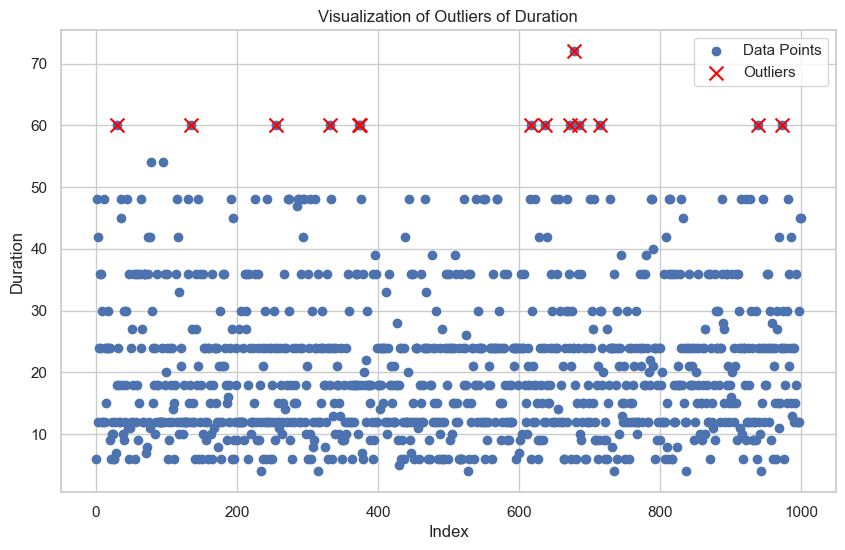

In [9]:
# Duration
# Outliers of Numeric Variables
z_scores = stats.zscore(df['Duration'])
threshold = 3
outliers = np.where(np.abs(z_scores) > threshold)


outlier_indices = np.where(np.abs(z_scores) > threshold)
outlier_values = df['Duration'].iloc[outlier_indices]

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Duration'], label='Data Points')

# Highlight the outliers
plt.scatter(outlier_indices, outlier_values, color='red', label='Outliers', marker='x', s=100)

plt.xlabel('Index')
plt.ylabel('Duration')
plt.title('Visualization of Outliers of Duration')
plt.legend()
plt.show()

After using a standard threshold of 3 deviations from the mean in outlier detection by z-score, it is seen that the outliers present in both duration and credit score features are not significant enough to cause removal. Similarly, the transformation of these numeric variables will affect the data distribution more than if they were left as is.

#### Distribution of Categorical Features vs Target

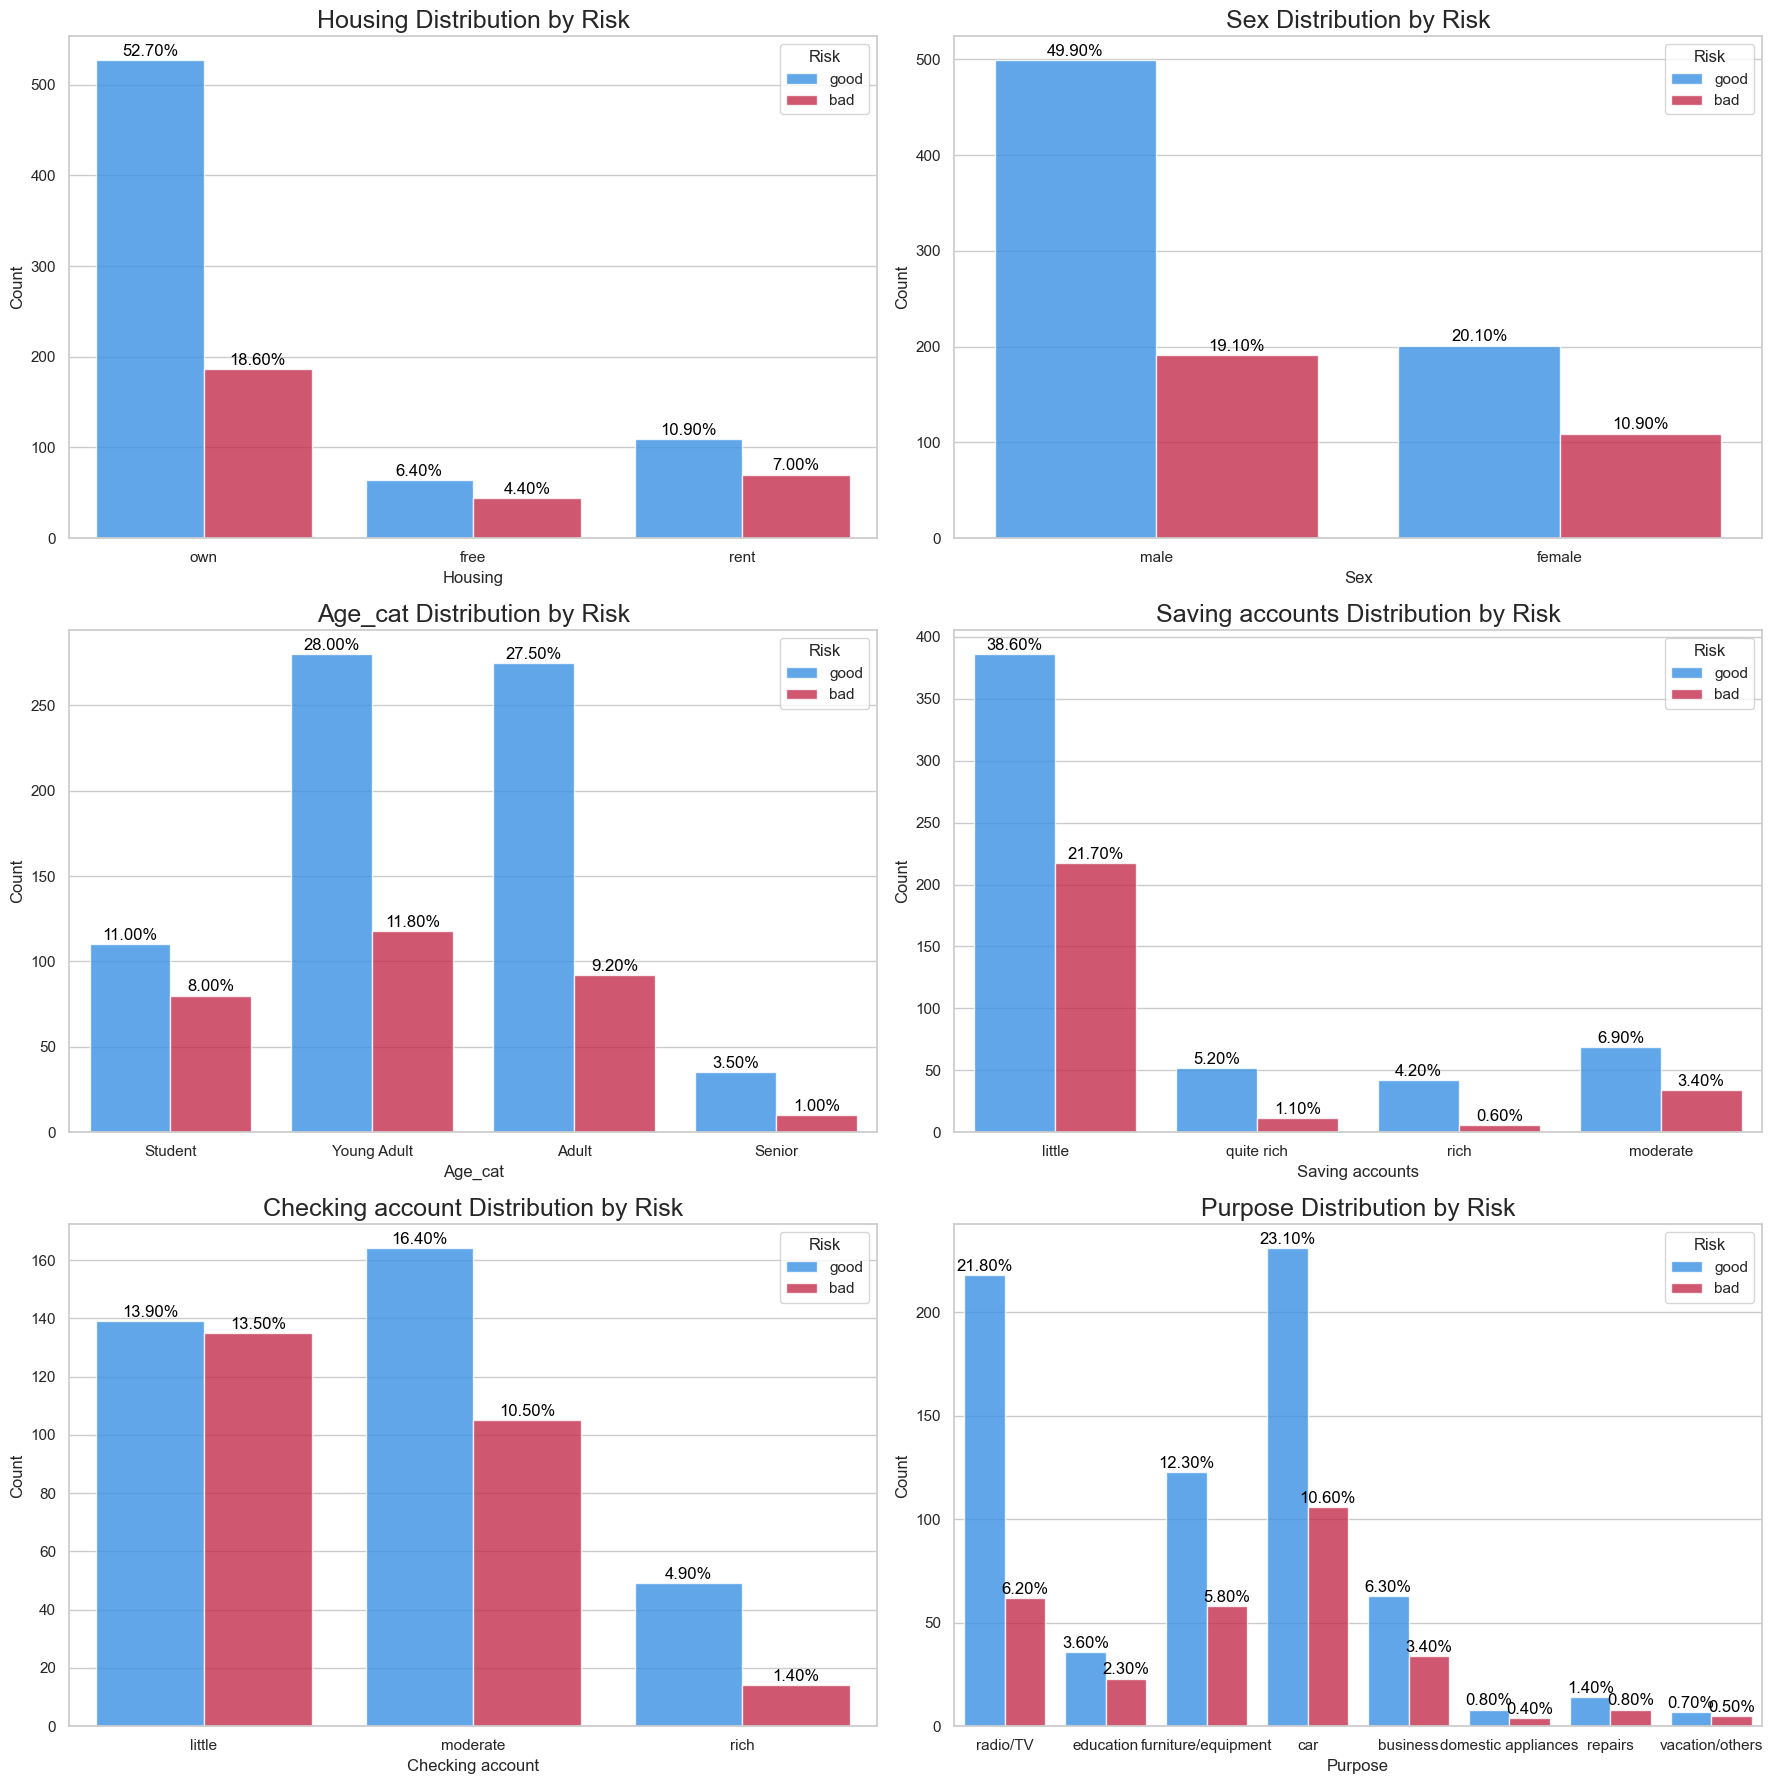

In [10]:
# Create a 3x2 grid of count plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
# Columns to plot
columns_to_plot = ['Housing', 'Sex', 'Age_cat', 'Saving accounts', 'Checking account', 'Purpose']

# Loop through columns and create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = sns.countplot(data=df, x=column, hue='Risk', alpha=0.8, palette={'good': 'dodgerblue', 'bad': 'crimson'}, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Distribution by Risk', fontsize=18)  
    
    # Add percentages on top of the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / len(df) * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', fontsize=12, color='black')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend(title='Risk', loc='upper right')
plt.show()

The plots above are created to show distribution of the categorical variables in relation to the target variable ("Hue=Risk"). Once again, the class imbalance is prominent in the dataset, this time in the categorical variables. Each categorical variable has a larger count of "good" credit records. 

### Data Preprocessing & Feature Engineering/Transformation
#### Imputing the missing values
#### Standarization of the numerical variables and one hot encoding of the categorical variables
#### Re-sampling due to the class imbalance

In [11]:
# Define categorical columns
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age_cat', 'Job']

# Define numerical columns
numerical_columns = ['Age', 'Credit amount', 'Duration']

# Replacing the nans in both columns with 'unknown'
df['Saving accounts'].fillna("unknown", inplace=True) 
df['Checking account'].fillna("unknown", inplace=True) 
unique_values_1 = df['Saving accounts'].unique()
unique_values_2 = df['Checking account'].unique()
print("New unique values for both features")
print(unique_values_1)
print(unique_values_2)

# One-Hot Encoding the Categorical Variables
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print(df.head(1), "\n \n ...... Categorical variables are now one-hot encoded \n")

# Scaling the Numerical Variables
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
print(df[numerical_columns], "\n \n ......... Numerical variables are now scaled \n")

# Re-sampling Due to Class Imbalance
X = df.drop('Risk', axis=1) 
y = df['Risk']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['Risk'] = y_resampled
print(print(resampled_df['Risk'].value_counts()), "\n \n ............ Re-sampling applied to deal with class imbalance \n")

# Map 'Risk' to binary values in order to work with ML models
risk_mapping = {'bad': 0, 'good': 1}
resampled_df['Risk_num'] = resampled_df['Risk'].map(risk_mapping)
# Drop the original 'Risk' column to avoid entering into the model and overfitting
resampled_df.drop(columns=['Risk'], inplace=True)

# Rename dataframe for consitency with the code that follows
df_processed = resampled_df
df_processed.head()

New unique values for both features
['unknown' 'little' 'quite rich' 'rich' 'moderate']
['little' 'moderate' 'unknown' 'rich']
   Age  Credit amount  Duration  Risk  Sex_male  Housing_own  Housing_rent  \
0   67           1169         6  good         1            1             0   

   Saving accounts_moderate  Saving accounts_quite rich  Saving accounts_rich  \
0                         0                           0                     0   

   ...  Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
0  ...                            0                 1                0   

   Purpose_vacation/others  Age_cat_Young Adult  Age_cat_Adult  \
0                        0                    0              0   

   Age_cat_Senior  Job_1  Job_2  Job_3  
0               1      0      1      0  

[1 rows x 27 columns] 
 
 ...... Categorical variables are now one-hot encoded 

          Age  Credit amount  Duration
0    2.766456      -0.745131 -1.236478
1   -1.191404       0.949817 

,Age,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,...,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_cat_Young Adult,Age_cat_Adult,Age_cat_Senior,Job_1,Job_2,Job_3,Risk_num
0,2.766456,-0.745131,-1.236478,1,1,0,0,0,0,1,...,1,0,0,0,0,1,0,1,0,1
1,-1.191404,0.949817,2.248194,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,0.831502,1.634247,1.750384,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,1.535122,0.566664,0.256953,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


We applied multiple data pre-processing steps that are essential for the proper development of our machine learning model to predict credit risk. It begins by defining categorical and numerical columns in the dataset, proceeds to handle missing values by imputing them with the most frequent values, and then one-hot encodes the categorical variables while scaling the numerical ones using StandardScaler. After that is done the class imbalance is addressed via SMOTE resampling, creating a balanced dataset for training the credit risk model that now has 700 records for each class. These preprocessing steps are essential for ensuring data quality, model readiness, and accurate credit risk assessment, making it particularly valuable for financial institutions seeking to make informed lending decisions while effectively managing risk.

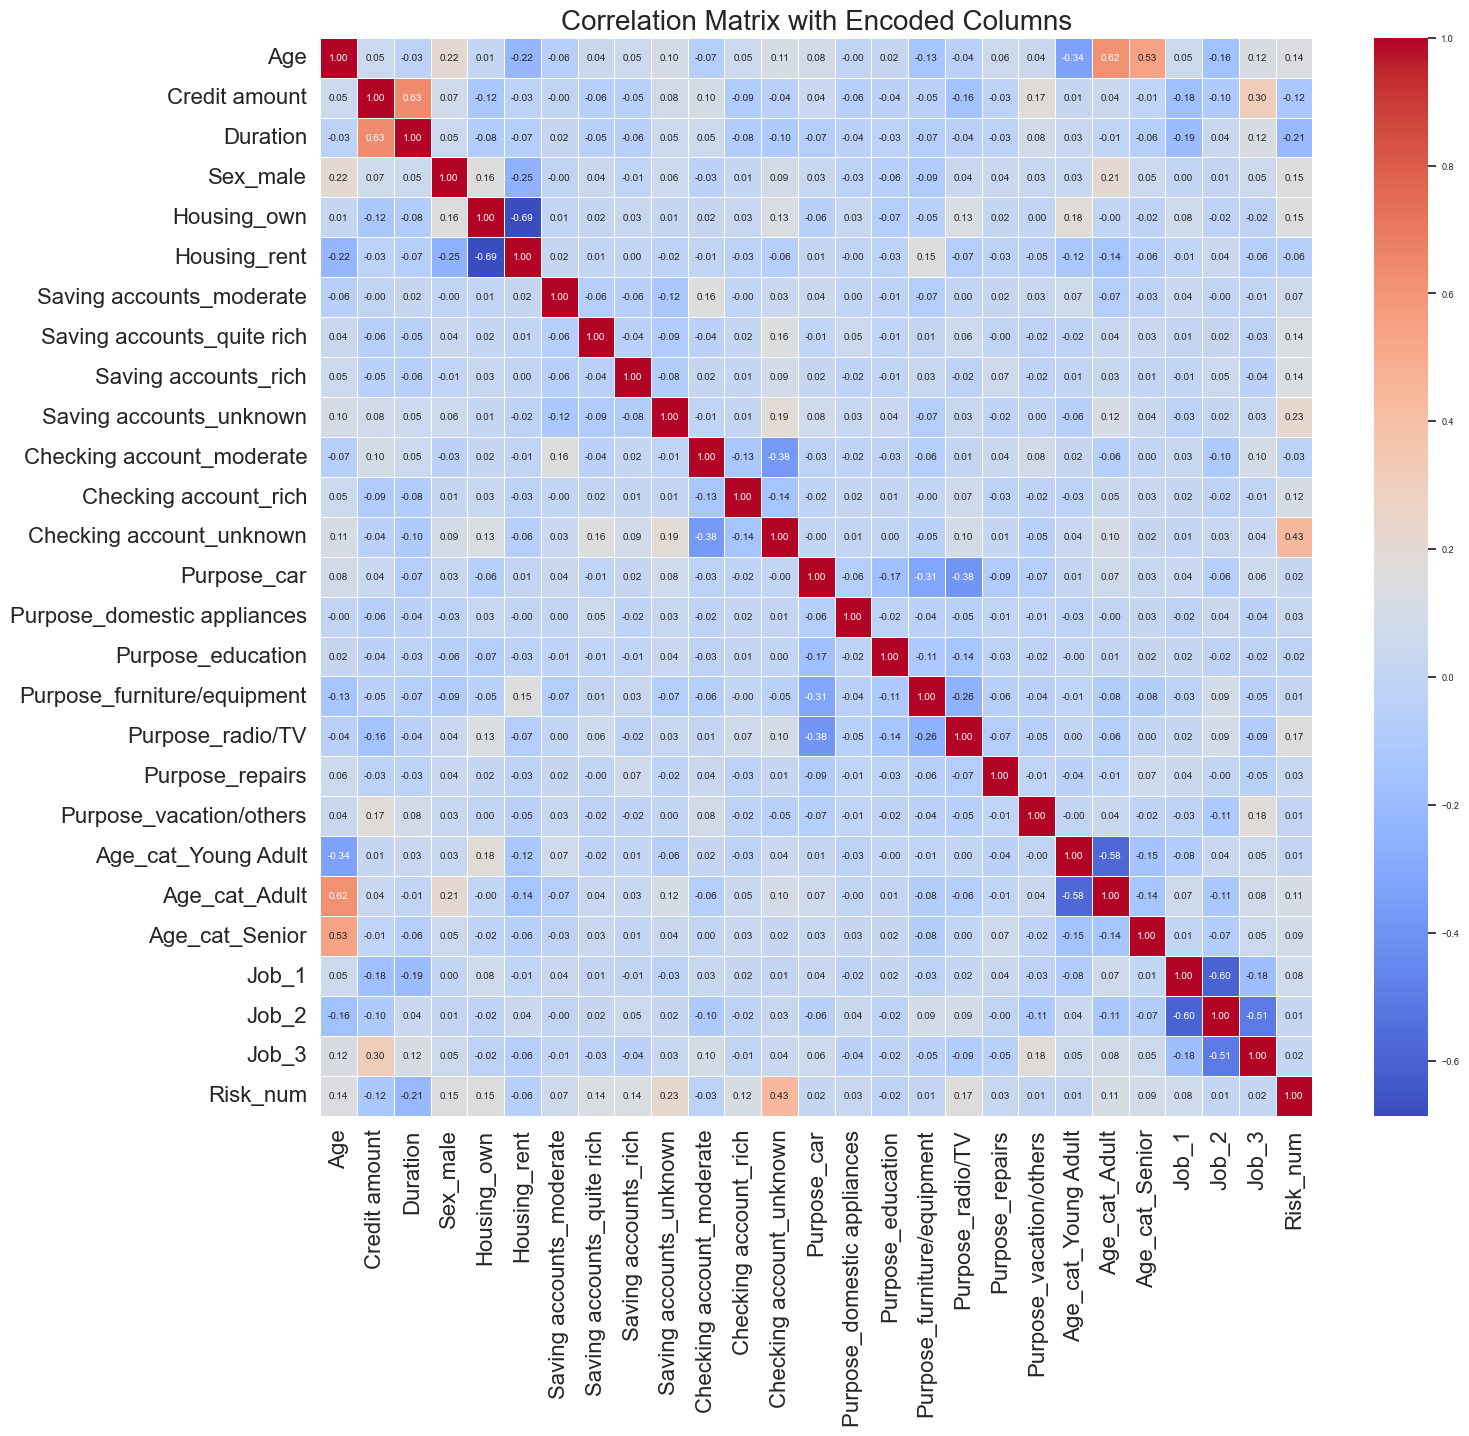

In [12]:
# Calculate the correlation matrix
correlation_matrix = df_processed.corr()

# Set up the figure and axis for the heatmap
plt.figure(figsize=(16, 14))
sns.set(font_scale=.6)  # Adjust the font scale if needed

# Create a heatmap of the correlation matrix
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix with Encoded Columns', size = 20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)  
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)  
  
plt.show()

After the preprocessing is done and the categorical variables are one-hot encoded, a correlation matrix is created to determine risk for multicollinearity and find to find potential beneficial relationships amongst variables. The above correlation matrix is accountable for all features and broken out categorical variables. The matrix does not show any significantly strong relationships and therefor suggests a low risk for multicollinearity.

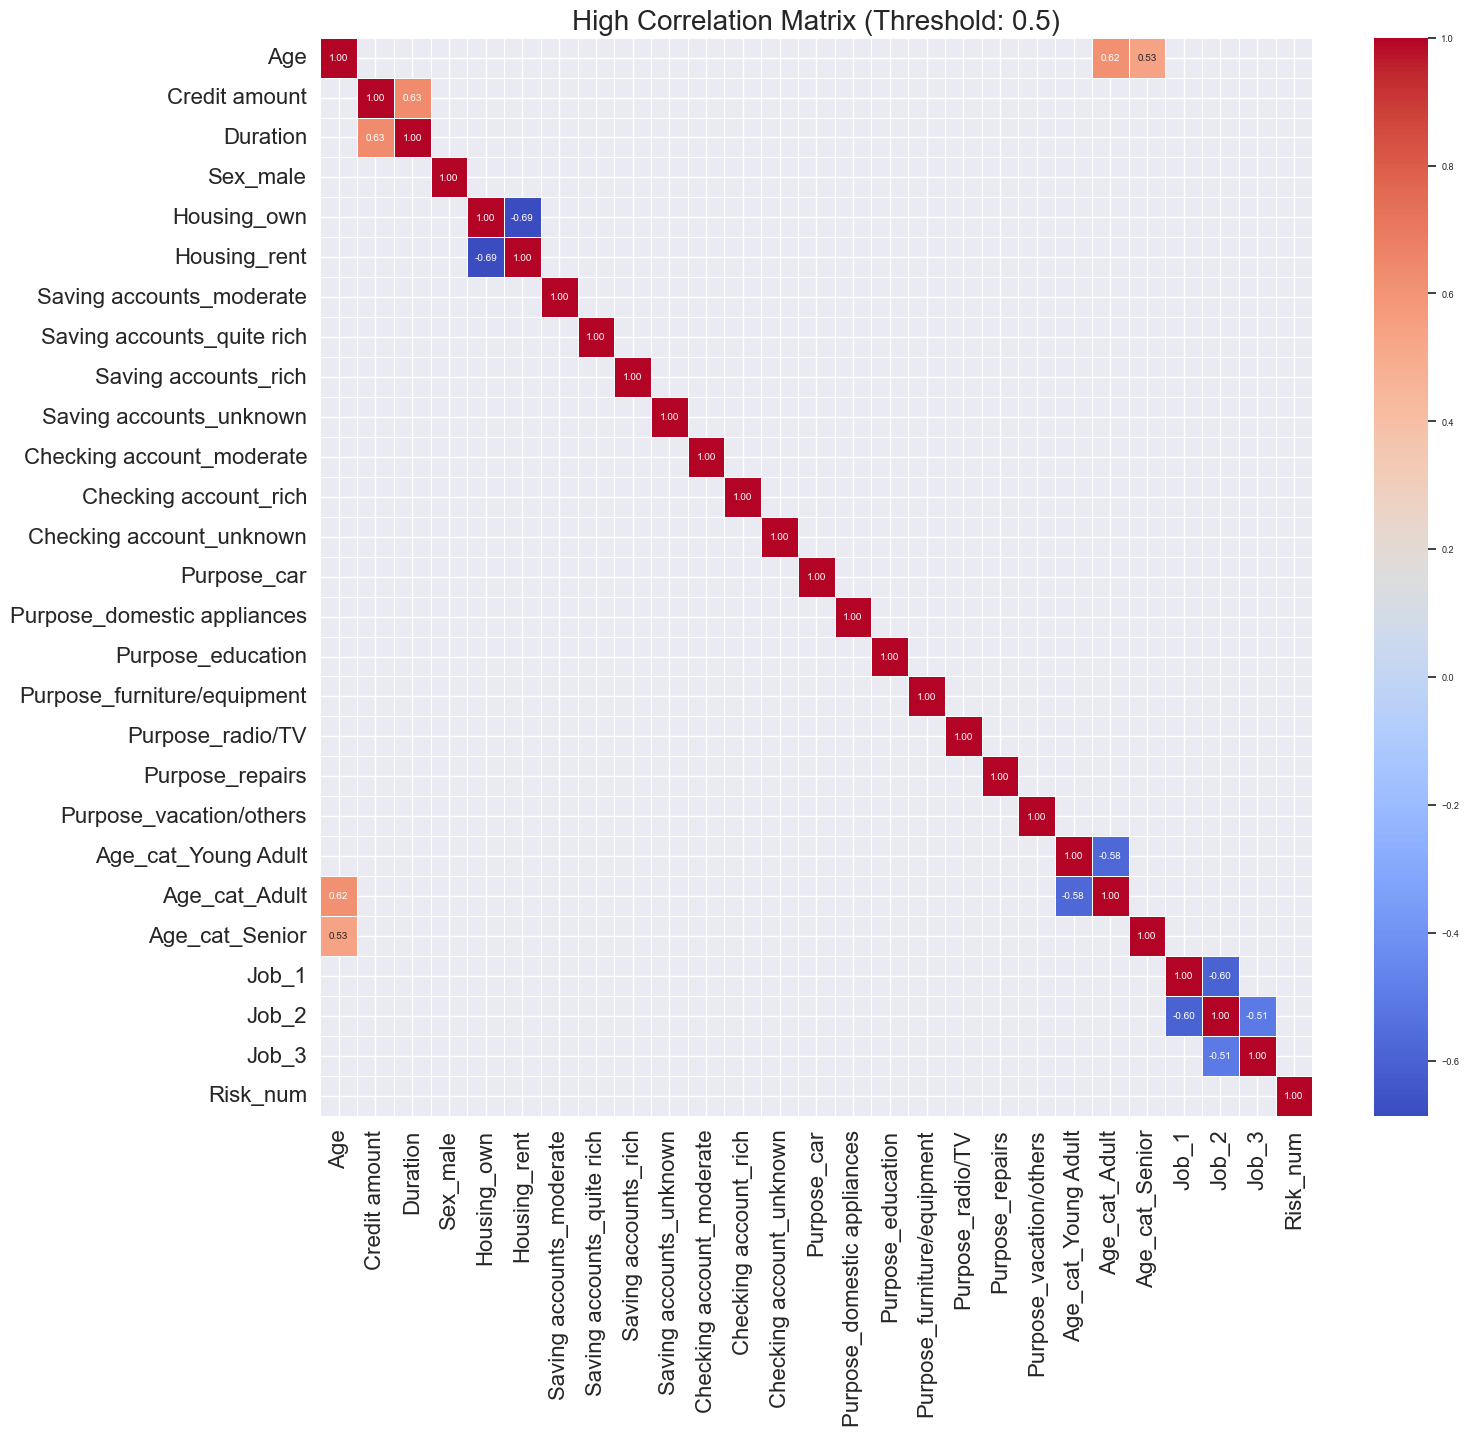

In [13]:
#for clarity, only show fields with a correlation that meet threshold
threshold = 0.5 

mask = abs(correlation_matrix) >= threshold

# generate heatmap with masked values
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(correlation_matrix[mask], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('High Correlation Matrix (Threshold: {})'.format(threshold), fontsize = 20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)

plt.show()

A second correlation matrix is created above, again with all features present in the data. In this visualization, the threshold is set to an absolute value of 0.5 for clarity of potential relationships amongst features. Again, no pertinent risk of multicollinearity.

## Machine Learning Classifiers

Class Distribution:
1    700
0    700
Name: Risk_num, dtype: int64


Classifiers Progress:   0%|     | 0/11 [00:00<?, ?it/s]

Random Forest - Feature Importances (ascending order):
Purpose_domestic appliances    0.001961
Purpose_vacation/others        0.002093
Purpose_repairs                0.006679
Age_cat_Senior                 0.007521
Purpose_education              0.008373
Housing_rent                   0.012618
Saving accounts_quite rich     0.013905
Job_1                          0.016158
Age_cat_Adult                  0.017406
Saving accounts_moderate       0.018105
Purpose_furniture/equipment    0.018777
Saving accounts_rich           0.018788
Age_cat_Young Adult            0.019366
Job_3                          0.020335
Checking account_rich          0.022020
Housing_own                    0.022765
Job_2                          0.023233
Checking account_moderate      0.027689
Sex_male                       0.028463
Purpose_car                    0.029619
Purpose_radio/TV               0.034282
Saving accounts_unknown        0.039797
Age                            0.135936
Duration                 

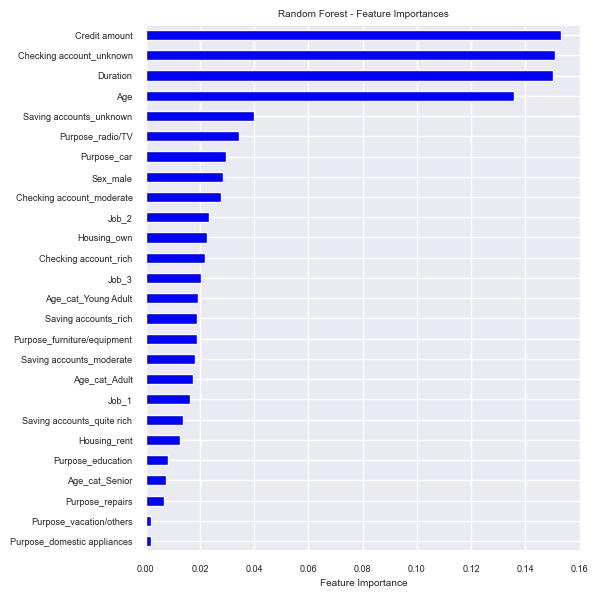

Classifiers Progress:   9%| | 1/11 [00:02<00:24,  2.41s

Decision Tree - Feature Importances (ascending order):
Purpose_domestic appliances    0.000000
Purpose_vacation/others        0.003079
Age_cat_Adult                  0.004485
Age_cat_Senior                 0.004905
Purpose_education              0.005835
Age_cat_Young Adult            0.008883
Housing_rent                   0.009712
Saving accounts_quite rich     0.009969
Purpose_repairs                0.010269
Job_3                          0.011177
Saving accounts_rich           0.012493
Saving accounts_moderate       0.013951
Job_2                          0.016889
Job_1                          0.018194
Purpose_radio/TV               0.021662
Housing_own                    0.022606
Purpose_furniture/equipment    0.022904
Checking account_rich          0.024798
Sex_male                       0.028118
Saving accounts_unknown        0.029183
Checking account_moderate      0.034701
Purpose_car                    0.035187
Age                            0.115654
Duration                 

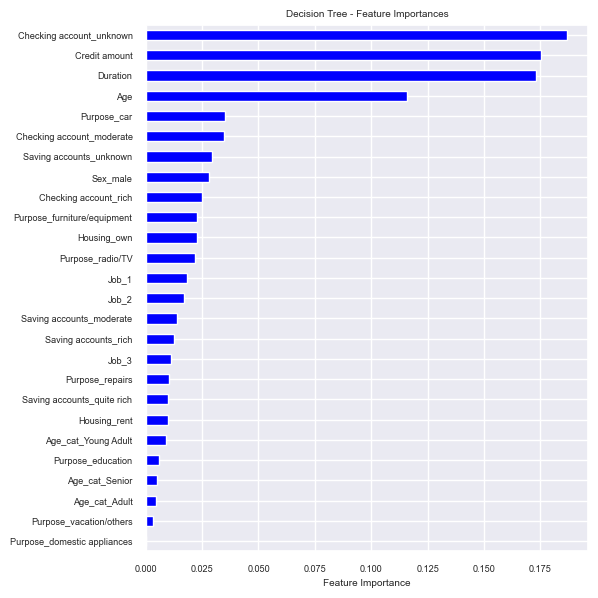

Classifiers Progress:  18%|▏| 2/11 [00:03<00:16,  1.86s

XGBoost - Feature Importances (ascending order):
Age_cat_Senior                 0.000000
Purpose_domestic appliances    0.006015
Purpose_education              0.007277
Age_cat_Adult                  0.012172
Purpose_vacation/others        0.013310
Housing_rent                   0.015864
Purpose_repairs                0.016210
Job_2                          0.017755
Housing_own                    0.018064
Age_cat_Young Adult            0.018692
Credit amount                  0.019544
Saving accounts_quite rich     0.019950
Job_1                          0.021462
Age                            0.021957
Sex_male                       0.026731
Purpose_radio/TV               0.030573
Purpose_furniture/equipment    0.031220
Checking account_moderate      0.031805
Purpose_car                    0.031987
Duration                       0.035042
Saving accounts_rich           0.041512
Job_3                          0.046135
Saving accounts_moderate       0.062929
Saving accounts_unknown        

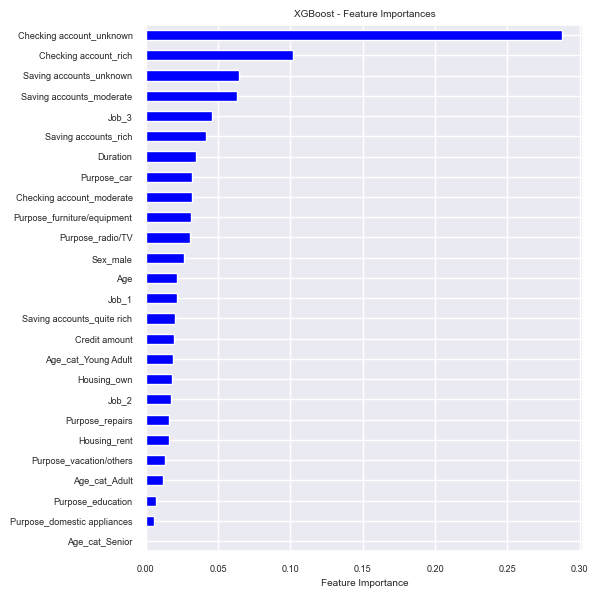

Classifiers Progress:  55%|▌| 6/11 [00:19<00:13,  2.60s

AdaBoost - Feature Importances (ascending order):
Job_3                          0.00
Age_cat_Senior                 0.00
Age_cat_Adult                  0.00
Housing_rent                   0.00
Purpose_repairs                0.00
Job_2                          0.00
Job_1                          0.02
Age_cat_Young Adult            0.02
Purpose_vacation/others        0.02
Purpose_education              0.02
Purpose_domestic appliances    0.02
Checking account_unknown       0.02
Checking account_moderate      0.02
Saving accounts_unknown        0.02
Saving accounts_rich           0.02
Saving accounts_quite rich     0.02
Saving accounts_moderate       0.02
Housing_own                    0.02
Sex_male                       0.02
Checking account_rich          0.02
Purpose_car                    0.04
Purpose_furniture/equipment    0.04
Purpose_radio/TV               0.06
Age                            0.08
Duration                       0.22
Credit amount                  0.28
dtype: float64

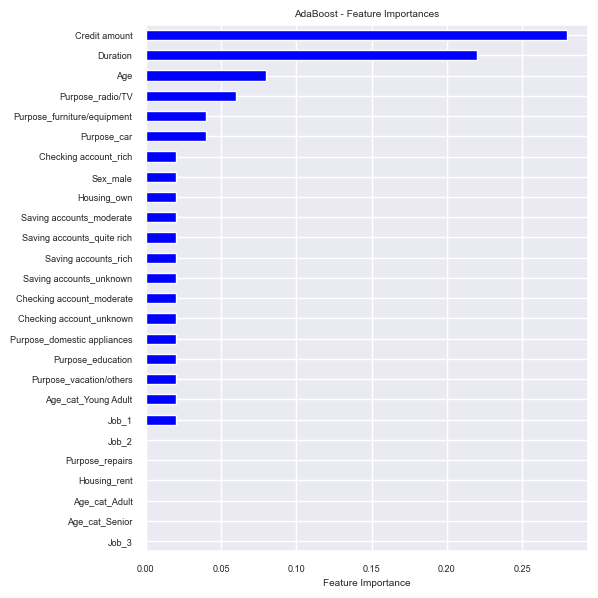

Classifiers Progress: 100%|█| 11/11 [00:22<00:00,  2.04

Random Forest - Evaluation Metrics:
Accuracy: 0.7928571428571428
Precision: 0.8527131782945736
Sensitivity/Recall: 0.738255033557047
Specificity: 0.8549618320610687
ROC AUC: 0.9017880014344997
Elapsed Time: 0.4422 seconds

Decision Tree - Evaluation Metrics:
Accuracy: 0.7714285714285715
Precision: 0.8102189781021898
Sensitivity/Recall: 0.7449664429530202
Specificity: 0.8015267175572519
ROC AUC: 0.773246580255136
Elapsed Time: 2.4278 seconds

XGBoost - Evaluation Metrics:
Accuracy: 0.825
Precision: 0.8571428571428571
Sensitivity/Recall: 0.8053691275167785
Specificity: 0.8473282442748091
ROC AUC: 0.8943593421794149
Elapsed Time: 10.5150 seconds

Neural Network - Evaluation Metrics:
Accuracy: 0.7714285714285715
Precision: 0.8346456692913385
Sensitivity/Recall: 0.7114093959731543
Specificity: 0.8396946564885496
ROC AUC: 0.8518366719606538
Elapsed Time: 19.1763 seconds

Logistic Regression - Evaluation Metrics:
Accuracy: 0.75
Precision: 0.7969924812030075
Sensitivity/Recall: 0.7114093959731

In [14]:
# Declare target variable and predictor variables
X = df_processed.drop(columns=['Risk_num'])
y = df_processed['Risk_num']

# Check class balance
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {}),
    'XGBoost': (XGBClassifier(random_state=42), {}),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {}),
    'Logistic Regression': (LogisticRegression(random_state=42), {}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {}),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

# Define start_time before the loop to evaluate processing time
start_time = time.time()

for name, (classifier, _) in tqdm(classifiers.items(), desc='Classifiers Progress'):
    # Train and evaluate the classifier as before
    classifier.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Obtain predicted probabilities for the positive class
    y_pred_probs = classifier.predict_proba(X_test.values)[:, 1]
    
    threshold = 0.5  # You can adjust this threshold as needed

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    feature_importances = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        
        # Sort feature importances in ascending order
        feature_importances = feature_importances.sort_values(ascending=True)
        
        # Print feature importances
        print(f"{name} - Feature Importances (ascending order):")
        print(feature_importances)
        
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'ROC AUC': roc_auc,
        'Elapsed Time': elapsed_time,
        'Feature Importances': feature_importances,
        'y_pred_probs': y_pred_probs  # Store the predicted probabilities
    }
    
    # Store the ROC AUC score for later plotting
    roc_auc_scores[name] = roc_auc

    # Plot feature importances and save to the "plots" folder
    if feature_importances is not None:
        plt.figure(figsize=(6, 6))
        feature_importances.plot(kind='barh', color="blue")  # Use the same color for all plots
        plt.xlabel('Feature Importance')
        plt.title(f'{name} - Feature Importances')
        plt.tight_layout()
        
        # Save the plot to the "plots" folder
        plots_folder = 'plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plot_filename = os.path.join(plots_folder, f'{name}_feature_importance_plot.png')
        plt.savefig(plot_filename)
        plt.show()

# Print results without numerical values
for name, metrics in results.items():
    print(f"{name} - Evaluation Metrics:")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()

The varying changes in feature importances across different models can be attributed to the inherent characteristics and algorithms of each model type, as well as the specific features involved. Random Forest, with its ensemble of decision trees, highlights 'Duration,' 'Age,' and 'Credit amount' as crucial due to its capacity to capture complex interactions among numerical features. Decision Trees, on the other hand, singularly emphasize 'Credit amount' as it makes splits based on the most informative feature at each node. XGBoost showcases the importance of 'Saving accounts,' 'Purpose,' 'Duration,' 'Age,' and 'Credit amount,' benefiting from its ability to discern intricate feature relationships. Conversely, AdaBoost focuses on 'Age,' 'Credit amount,' and 'Duration,' aiming to reduce misclassification through weighted emphasis. These varying feature importances underscore the model-specific strengths and the need to select models aligning with business goals and domain expertise, as different algorithms may capture distinct aspects of credit risk assessment.

Among the various models evaluated for automating the credit loan approval process, the XGBoost model stands out as the most promising choice. It achieves a commendable accuracy of approximately 76.1% and strikes a good balance between precision (77.7%) and recall (77.2%), indicating that it effectively identifies both approved and declined credit applications. Additionally, the XGBoost model exhibits a strong ROC AUC score of 0.818, suggesting robust discrimination between good and bad credit applicants. Importantly, it achieves these impressive results in a relatively reasonable elapsed time of 3.95 seconds, making it efficient for real-time application processing. In the context of the business problem, where timely responses to applicants are crucial to prevent them from seeking loans elsewhere, the XGBoost model's combination of accuracy, efficiency, and balanced precision-recall performance makes it the model of choice.

From a non-technical perspective, selecting the XGBoost model for automating credit loan approvals offers several compelling advantages for our business. This model not only achieves a commendable accuracy rate, ensuring that our decisions align with customer eligibility, but it also strikes an excellent balance between precision and recall. This balance means that our model effectively identifies applicants who are both eligible for loans and those who should be declined, minimizing both the risk of defaults and the loss of potential customers to competitors. Moreover, the model's strong ROC AUC score demonstrates its ability to distinguish between good and bad applicants, further enhancing our risk assessment capabilities. Importantly, the XGBoost model achieves these results efficiently, processing applications in under four seconds, which is crucial for providing timely responses and retaining customers. In essence, the XGBoost model offers the optimal blend of accuracy, efficiency, and balanced decision-making, aligning perfectly with our goal of streamlining the credit approval process and providing a competitive edge in the industry.

#### Evaluation Metrics Visualization

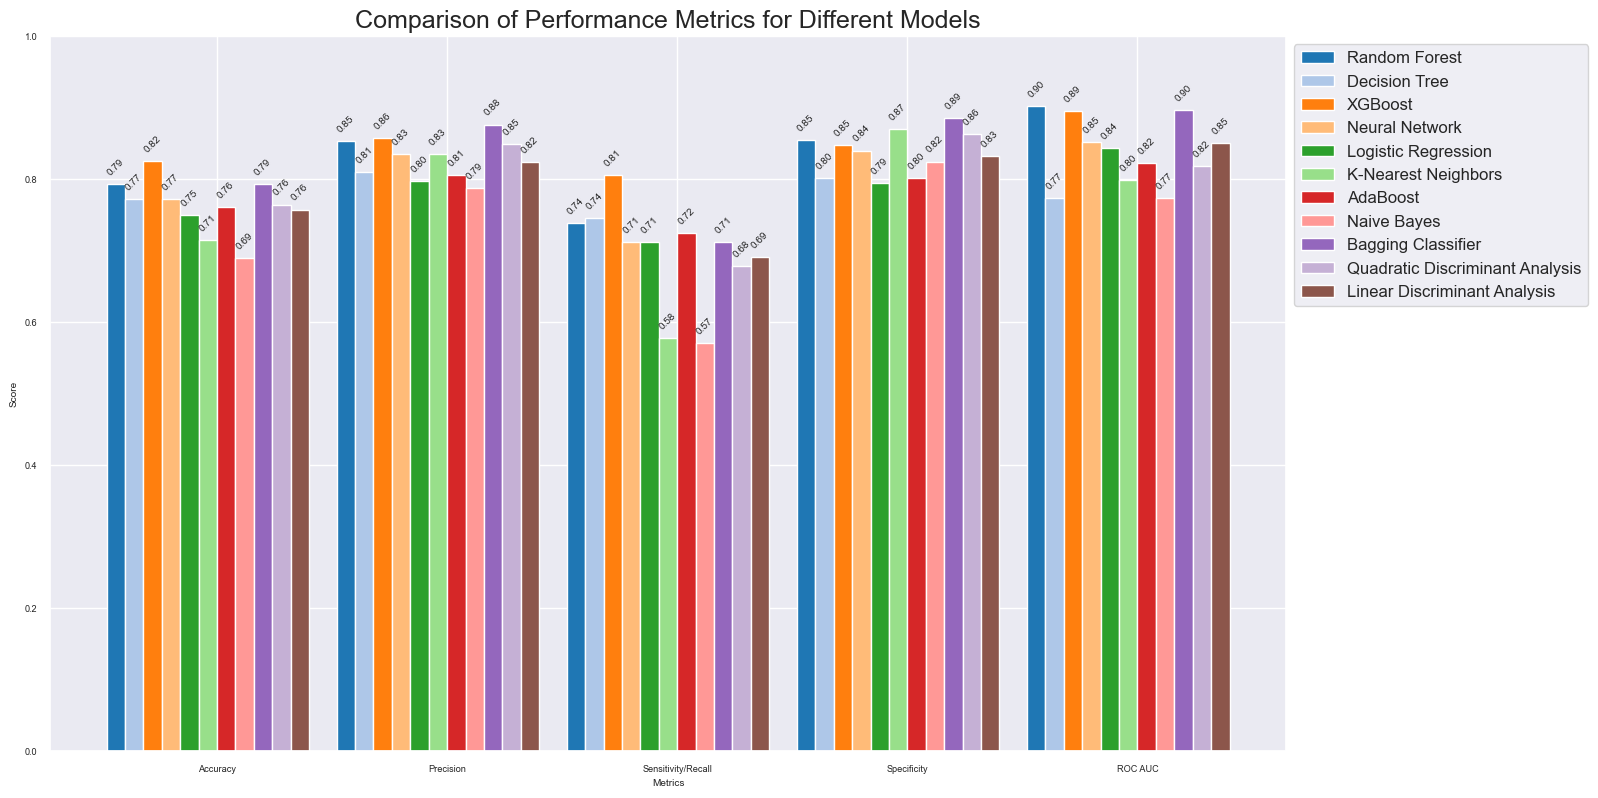

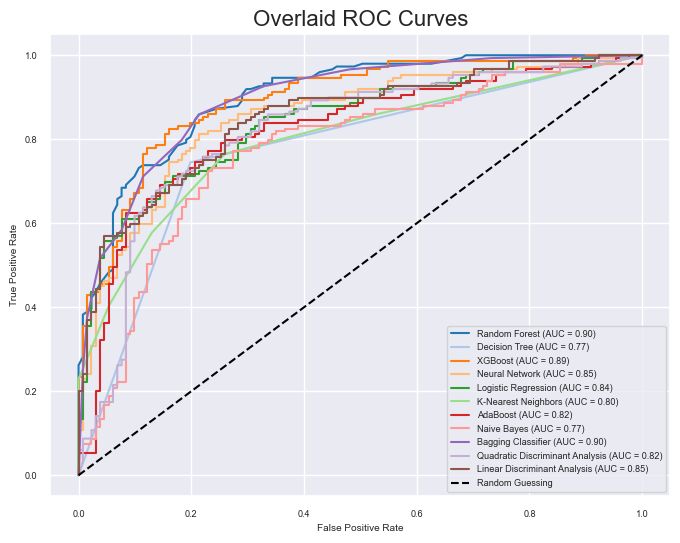

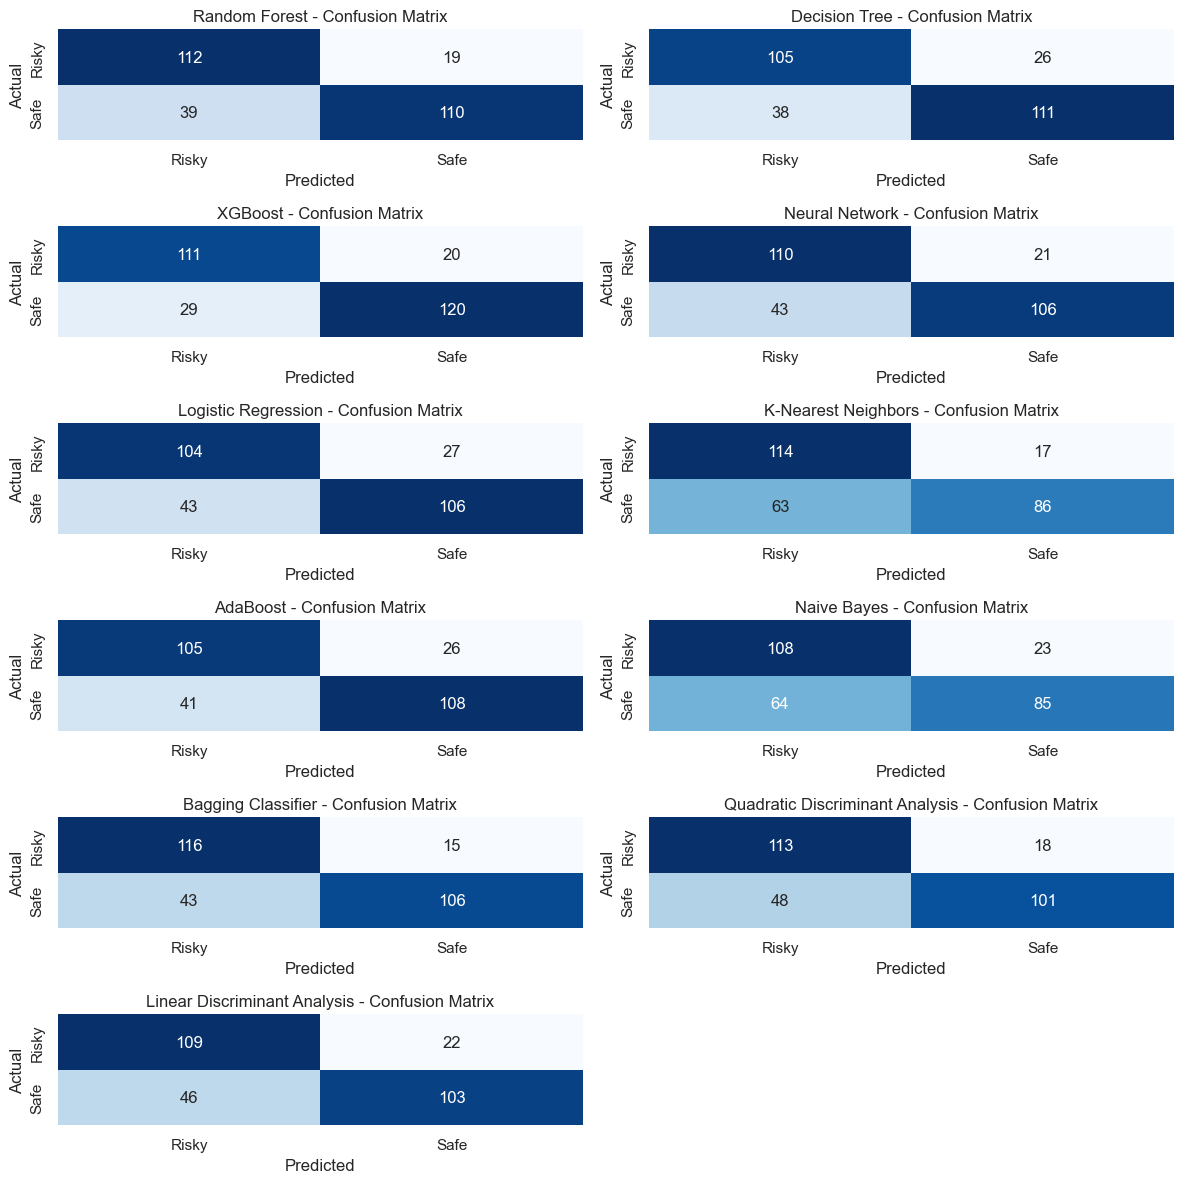

In [15]:
# List of metrics to include in the bar plot
metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Define the width of each group of bars
bar_width = 0.08

# Create an array of x positions for each set of bars
x_positions = np.arange(len(metrics_to_plot))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Iterate through each classifier and plot the metrics
for i, (name, metrics) in enumerate(results.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    x = x_positions + i * bar_width
    
    bars = ax.bar(x, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
                ha='center', va='bottom', rotation=45) 

# Configure plot settings
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics for Different Models', fontsize=18)
ax.set_xticks(x_positions + bar_width * len(results) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax.set_ylim(0, 1)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'performance_metrics_comparison.png')
plt.savefig(plot_filename)
plt.tight_layout()
plt.show()

# Initialize an empty figure
plt.figure(figsize=(8, 6))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model
for i, name in enumerate(roc_auc_scores.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves', fontsize=16)
plt.legend()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'overlaid_roc_curve.png')
plt.savefig(plot_filename)

# Show the plot
plt.show()
# Define the path to the plots folder
plots_folder = 'plots'

# Create the plots folder if it doesn't exist
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# Create a grid of confusion matrices
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers) // 2 + len(classifiers) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix = confusion_matrix(y_test, results[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Risky', 'Safe'], yticklabels=['Risky', 'Safe'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot
combined_plot_filename = os.path.join(plots_folder, 'confusion_matrix_combined.png')
plt.savefig(combined_plot_filename)
plt.show()

In further support of the XG Boost model, the visualization above records the this model also has the highest AUC, or area under the curve. This value is the closest to 1 of the eleven models representing a model that is properly classifying positive and negative classes at different thresholds. As mentioned previously, all eleven models have similar evaluation metrics, with each of them performing well in different categories. The confusion matrices above confirm that the models are classifying similarly. Each matrix has a similar number of true positive and true negative classifications. Across all eleven models, the team would like to see higher volume in the true positive class. However, these classifications can be modified to the German Banking Company's business needs based on different rules by determining different thresholds. For example, the company needs to determine if they are more concerned with the amount of manual reviews needed on high risk consumers, or the amount of consumers being classified as low risk that are being trusted based on the algorithm.

Fine-tuning a machine learning model to optimize sensitivity, specificity, and precision is crucial in addressing distinct business requirements. For a credit loan approval system, specific scenarios dictate the need for adjustments. When a business is highly risk-averse and aims to minimize defaults, prioritizing specificity becomes paramount. This sharpens the model's ability to identify non-creditworthy applicants accurately, reducing financial losses. Conversely, in competitive markets, where customer retention and market share matter most, focusing on sensitivity ensures that the institution does not lose potentially profitable customers. Regulatory adherence calls for a balance between both specificity and sensitivity, ensuring due diligence in credit assessments. Efficiency gains significance to prevent customers from turning elsewhere for loans, a goal exemplified by the XGBoost model's swift processing times. This enhancement in efficiency contributes to an improved customer experience, aiding customer retention. For maintaining a reputable customer base and portfolio quality, especially in established institutions, amplifying specificity safeguards against risky approvals. Additionally, a well-optimized model can enhance profitability by reducing defaults and associated costs. Flexibility to adapt to changing market conditions is also crucial. In this context, the XGBoost model's balanced performance aligns with the institution's objectives of streamlining credit approval processes, providing timely responses, and retaining customers while effectively managing risk. However, it's essential to remain open to model adjustments based on the institution's evolving priorities and the regulatory landscape.

### Feature Selection & Parameter Optimization of Best Performing Model (XGBoost)

In the evaluation of feature importances for predicting credit risk, several key insights emerge. Firstly, features related to 'Saving Accounts Status' (moderate, rich, quite rich) exhibit the highest importance scores. These features effectively gauge an applicant's financial stability and savings, with richer account holders being associated with lower credit risks, aligning with the conventional wisdom that greater savings capacity enhances an applicant's ability to meet financial obligations. Secondly, 'Purpose of the Loan' features, particularly those indicating specific loan purposes like 'radio/TV' or 'car,' hold considerable importance. Such loans typically come with well-defined repayment plans, rendering applicants seeking them as lower credit risks. Thirdly, the 'Duration' of the loan is another pivotal factor in credit risk assessment. Longer durations tend to signal higher risk due to the extended time frame for unforeseen events. Fourthly, the status of an applicant's 'Checking Account' (rich) is a strong indicator of financial stability and a key determinant of creditworthiness. Those with substantial funds in their checking accounts are perceived as lower credit risks. Additionally, homeownership status ('Housing_own') plays a significant role. It signifies stability and commitment, making homeowners appear as lower credit risks. Age also bears relevance, with younger applicants ('Age_cat_Young Adult') considered riskier due to limited credit histories, while more experienced individuals ('Age_cat_Adult' and 'Age_cat_Senior') are seen as lower risks, reflecting the influence of age on financial stability and risk-taking behavior. 'Credit Amount,' although not the most influential, still matters in credit risk assessment, with higher credit amounts posing increased risk if not commensurate with an applicant's financial capacity. 

Conversely, certain features rank lower in importance. For instance, 'Purpose of the Loan' related to 'domestic appliances' lacks predictive power, potentially due to smaller loan amounts and shorter durations associated with such purposes. Similarly, the 'Senior' age category has lower importance, likely due to diverse financial situations among senior applicants. 'Vacation/other' loan purposes and the 'Young Adult' age category also exhibit lower importance, possibly reflecting the discretionary nature of such loans and the financial volatility of young adults. Furthermore, 'furniture/equipment' and 'repairs' loan purposes, as well as 'moderate' checking account status and 'Job' categories (1, 2, 3), show modest importances, suggesting that other factors like savings and specific loan purposes have a more substantial influence on credit risk in this dataset. These insights collectively illuminate the key determinants of credit risk and inform the model's predictive capabilities for responsible lending and risk management.

XGBoost - Evaluation Metrics (Selected Features for XGBoost):
Accuracy: 0.8142857142857143
Precision: 0.8439716312056738
Recall: 0.7986577181208053
Specificity: 0.8320610687022901
ROC AUC: 0.8960500025616067


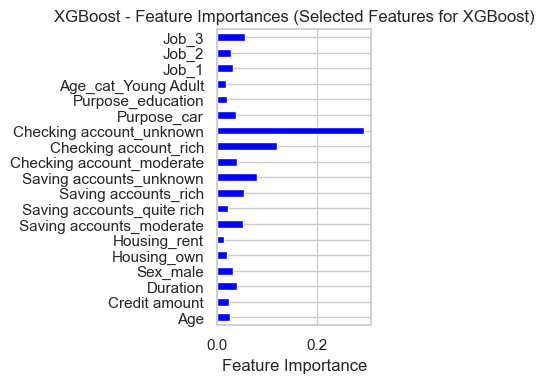

Random Forest - Evaluation Metrics (Selected Features for Random Forest):
Accuracy: 0.7571428571428571
Precision: 0.7872340425531915
Recall: 0.7449664429530202
Specificity: 0.7709923664122137
ROC AUC: 0.8382345407039294


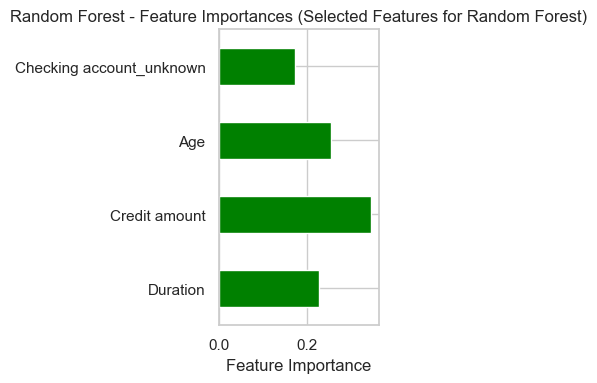

In [16]:
# Use features with highest feature importance
selected_features_xgb = ['Age', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 'Saving accounts_unknown',
       'Checking account_moderate', 'Checking account_rich', 'Checking account_unknown', 'Purpose_car', 'Purpose_education',
        'Age_cat_Young Adult', 'Job_1', 'Job_2', 'Job_3']

selected_features_rf = ['Duration', 'Credit amount', 'Age', 'Checking account_unknown']

# Extract the selected features from your dataset for XGBoost
X_xgb = df_processed[selected_features_xgb]

# Extract the selected features from your dataset for Random Forest
X_rf = df_processed[selected_features_rf]

# Split the data into training and testing sets for XGBoost
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier with default hyperparameters
xgb_classifier = XGBClassifier(random_state=42)

# Train the XGBoost classifier for XGBoost selected features
xgb_classifier.fit(X_train_xgb, y_train_xgb)

# Evaluate the XGBoost classifier for XGBoost selected features
y_pred_probs_xgb = xgb_classifier.predict_proba(X_test_xgb)[:, 1]

threshold = 0.5
y_pred_xgb = (y_pred_probs_xgb > threshold).astype(int)

accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
precision_xgb = precision_score(y_test_xgb, y_pred_xgb)
recall_xgb = recall_score(y_test_xgb, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = conf_matrix_xgb.ravel()
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
roc_auc_xgb = roc_auc_score(y_test_xgb, y_pred_probs_xgb)

feature_importances_xgb = pd.Series(xgb_classifier.feature_importances_, index=X_xgb.columns)

# Print evaluation metrics for XGBoost with selected features
print("XGBoost - Evaluation Metrics (Selected Features for XGBoost):")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Specificity: {specificity_xgb}")
print(f"ROC AUC: {roc_auc_xgb}")

# Plot feature importances for XGBoost with selected features
plt.figure(figsize=(4, 4))
feature_importances_xgb.plot(kind='barh', color="blue")
plt.xlabel('Feature Importance')
plt.title('XGBoost - Feature Importances (Selected Features for XGBoost)')
plt.tight_layout()
plt.show()

# Split the data into training and testing sets for Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Initialize Random Forest classifier with default hyperparameters
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier for Random Forest selected features
rf_classifier.fit(X_train_rf, y_train_rf)

# Evaluate the Random Forest classifier for Random Forest selected features
y_pred_rf = rf_classifier.predict(X_test_rf)
y_pred_probs_rf = rf_classifier.predict_proba(X_test_rf)[:, 1]

accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
precision_rf = precision_score(y_test_rf, y_pred_rf)
recall_rf = recall_score(y_test_rf, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)
roc_auc_rf = roc_auc_score(y_test_rf, y_pred_probs_rf)

feature_importances_rf = pd.Series(rf_classifier.feature_importances_, index=X_rf.columns)

# Print evaluation metrics for Random Forest with selected features
print("Random Forest - Evaluation Metrics (Selected Features for Random Forest):")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"Specificity: {specificity_rf}")
print(f"ROC AUC: {roc_auc_rf}")

# Plot feature importances for Random Forest with selected features
plt.figure(figsize=(4, 4))
feature_importances_rf.plot(kind='barh', color="green")
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importances (Selected Features for Random Forest)')
plt.tight_layout()
plt.show()


### Parameter Optimization of the Best Performing Model (XGBoost)

In [ ]:
# Use features with highest feature importance
selected_features = ['Age', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_moderate', 'Checking account_rich', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Age_cat_Young Adult', 'Age_cat_Adult',
       'Age_cat_Senior', 'Job_1', 'Job_2', 'Job_3']

# Extract the selected features from your dataset
X = df_processed[selected_features]  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Define a parameter grid for Grid Search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],          # Number of trees in the ensemble, Standard: 100
    'max_depth': [2, 5, 10],               # Maximum depth of each tree, Standard: 3
    'learning_rate': [0.1, 0.3, 0.5],  # Step size shrinkage to prevent overfitting, Standard: 0.3
    'subsample': [0.1, 0.5, 1.0],            # Fraction of samples used for training each tree, Standard: 1.0
    'colsample_bytree': [0.1, 0.5, 1.0],     # Fraction of features used for training each tree, Standard: 1.0
    'gamma': [0, 0.5, 1]              # Minimum loss reduction required to make a further partition on a leaf node, Standard: 0
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define a parameter grid for Grid Search for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],       # Number of trees in the forest, Standard: 100
    'max_depth': [2, 5, 10],             # Maximum depth of each tree, Standard: None
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node, Standard: 2
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node, Standard: 1
    'max_features': ['auto', 'sqrt'],     # Number of features to consider when looking for the best split, Standard: 'auto'
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees, Standard: True
}

# Initialize Grid Search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid_xgb, 
                               scoring='accuracy', cv=5, n_jobs=-1)

# Define start_time before running the grid search for XGBoost
start_time_xgb = time.time()

# Perform Grid Search to find the best parameters for XGBoost
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters from Grid Search for XGBoost
best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

# Train the XGBoost classifier with the best parameters for XGBoost
best_xgb_classifier = XGBClassifier(random_state=42, **best_params_xgb)
best_xgb_classifier.fit(X_train, y_train)

# Evaluate the XGBoost classifier for XGBoost selected features
y_pred_probs_xgb = best_xgb_classifier.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred_xgb = (y_pred_probs_xgb > threshold).astype(int)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = conf_matrix_xgb.ravel()
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_probs_xgb)

feature_importances_xgb = pd.Series(best_xgb_classifier.feature_importances_, index=X.columns)

# Print evaluation metrics for XGBoost with selected features
print("XGBoost - Evaluation Metrics (Parameter Optimization):")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Specificity: {specificity_xgb}")
print(f"ROC AUC: {roc_auc_xgb}")

# Plot feature importances for XGBoost with selected features
plt.figure(figsize=(4, 4))
feature_importances_xgb.plot(kind='barh', color="blue")
plt.xlabel('Feature Importance')
plt.title('XGBoost - Feature Importances (Selected Features for XGBoost)')
plt.tight_layout()
plt.show()

# Initialize Grid Search with cross-validation for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, 
                              scoring='accuracy', cv=5, n_jobs=-1)

# Define start_time before running the grid search for Random Forest
start_time_rf = time.time()

# Perform Grid Search to find the best parameters for Random Forest
grid_search_rf.fit(X_train, y_train)

# Get the best parameters from Grid Search for Random Forest
best_params_rf = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

# Train the Random Forest classifier with the best parameters for Random Forest
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the Random Forest classifier for Random Forest selected features
y_pred_rf = best_rf_classifier.predict(X_test)
y_pred_probs_rf = best_rf_classifier.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_probs_rf)

feature_importances_rf = pd.Series(best_rf_classifier.feature_importances_, index=X.columns)

# Print evaluation metrics for Random Forest with selected features
print("Random Forest - Evaluation Metrics (Parameter Optimization):")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"Specificity: {specificity_rf}")
print(f"ROC AUC: {roc_auc_rf}")

# Plot feature importances for Random Forest with selected features
plt.figure(figsize=(4, 4))
feature_importances_rf.plot(kind='barh', color="green")
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importances (Selected Features for Random Forest)')
plt.tight_layout()
plt.show()

### Use PCA Transformed Features as Predictors

In [ ]:
X = df_processed.drop(columns=['Risk_num'])
y = df_processed['Risk_num']

# Apply PCA to the resampled data
pca = PCA(n_components=10)  # Choose the number of components you want to retain
X_pca = pca.fit_transform(X)

# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Create a figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Scree plot with dots and a line (ax1)
scree_plot = ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Scree Plot', color='b')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color='b')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a second y-axis for the Cumulative Explained Variance plot (ax2)
ax2 = ax1.twinx()
cumulative_plot = ax2.bar(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, alpha=0.5, label='Cumulative Explained Variance', color='r')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine the legend handles and labels from both axes (ax1 and ax2)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

# Move the legend to the top middle of the plot
legend = ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1))

# Add text annotations for the Scree plot values and print them
scree_values = [f'{value:.2f}' for value in explained_variance_ratio]
for i, value in enumerate(explained_variance_ratio):
    ax1.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
    print(f'Scree Plot - Component {i + 1}: {scree_values[i]}')

# Add text annotations for the Cumulative Explained Variance values and print them
cumulative_values = [f'{value:.2f}' for value in cumulative_variance_ratio]
for i, value in enumerate(cumulative_variance_ratio):
    ax2.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
    print(f'Cumulative Explained Variance - Component {i + 1}: {cumulative_values[i]}')

# Adjust layout and show the combined plot
fig.tight_layout()
plt.show()

# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize classifiers for PCA-transformed data
classifiers_pca = {
    'Random Forest': (RandomForestClassifier(random_state=42), {}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {}),
    'XGBoost': (XGBClassifier(random_state=42), {}),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {}),
    'Logistic Regression': (LogisticRegression(random_state=42), {}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {}),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores for PCA-transformed data
results_pca = {}
roc_auc_scores_pca = {}

# Define start_time before the loop for PCA-transformed data
start_time_pca = time.time()

for name, (classifier, _) in tqdm(classifiers_pca.items(), desc='Classifiers Progress (PCA)'):
    # Train and evaluate the classifier on PCA-transformed data
    classifier.fit(X_train_pca, y_train_pca)
    end_time_pca = time.time()
    elapsed_time_pca = end_time_pca - start_time_pca

    # Obtain predicted probabilities for the positive class
    y_pred_probs_pca = classifier.predict_proba(X_test_pca)[:, 1]

    threshold = 0.5  # You can adjust this threshold as needed

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred_pca = (y_pred_probs_pca > threshold).astype(int)

    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    precision_pca = precision_score(y_test_pca, y_pred_pca)
    recall_pca = recall_score(y_test_pca, y_pred_pca)
    conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
    tn_pca, fp_pca, fn_pca, tp_pca = conf_matrix_pca.ravel()
    specificity_pca = tn_pca / (tn_pca + fp_pca)
    roc_auc_pca = roc_auc_score(y_test_pca, y_pred_probs_pca)

    feature_importances_pca = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances_pca = pd.Series(classifier.feature_importances_, index=range(1, X_pca.shape[1] + 1))

    results_pca[name] = {
        'Accuracy': accuracy_pca,
        'Precision': precision_pca,
        'Sensitivity/Recall': recall_pca,
        'Specificity': specificity_pca,
        'ROC AUC': roc_auc_pca,
        'Elapsed Time': elapsed_time_pca,
        'Feature Importances': feature_importances_pca,
        'y_pred_probs': y_pred_probs_pca  # Store the predicted probabilities
    }

    # Store the ROC AUC score for later plotting
    roc_auc_scores_pca[name] = roc_auc_pca

# Print results without numerical values for PCA-transformed data
for name, metrics in results_pca.items():
    print(f"{name} - Evaluation Metrics (PCA):")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()

The analysis of the Scree plot and Cumulative Explained Variance plot reveals valuable insights into the use of PCA analysis and dimensionality reduction for building a classification model to predict credit risk. The Scree plot demonstrates that the explained variance sharply decreases after the first few principal components, indicating that the majority of the data's variance can be captured by retaining only a subset of components. The Cumulative Explained Variance plot reinforces this trend, showing that by including the first four components, we explain 40% of the total variance, and by the tenth component, 71%.

From a technical perspective, this suggests that employing PCA for dimensionality reduction can be advantageous. By selecting the most informative principal components, we can significantly reduce the feature space while maintaining a substantial portion of the data's variance. This reduction in dimensionality can lead to more efficient model training and potentially enhanced model generalization.

However, it's important to consider the trade-offs. Using all original features might yield slightly higher model accuracy, but it can also introduce challenges related to high dimensionality, such as increased computational complexity and a higher risk of overfitting. In the context of predicting credit risk, where model interpretability and computational efficiency are essential, the use of PCA aligns well with these objectives. It strikes a balance between model accuracy and practicality, allowing for explainable and reliable credit risk assessments while discarding less informative dimensions. Ultimately, the choice of whether to use PCA should be tailored to the specific business needs and the desired trade-offs between accuracy, efficiency, and interpretability.

Dimensionality reduction methods like Principal Component Analysis (PCA) offer distinct advantages over conventional feature importance techniques, such as those utilized in Random Forest or ensemble models. A key strength lies in their potential for enhanced efficiency and reduced bias during feature selection. PCA objectively identifies and selects informative principal components based on the variance they capture, avoiding the subjectivity and potential biases inherent in traditional feature selection methods. This objectivity is particularly valuable when dealing with complex datasets where human-driven feature selection may introduce confirmation biases or domain-specific assumptions. Moreover, PCA significantly reduces dimensionality, leading to more efficient model training, while its handling of multicollinearity enhances model stability. In the context of credit risk prediction or other data-driven tasks, PCA's objectivity and efficiency contribute to transparent and fair model building, ensuring that feature selection remains data-driven rather than influenced by subjective judgments or biases. This approach ultimately bolsters the reliability and credibility of the model's predictions, aligning with best practices for responsible AI and data science.

#### PCA ROC Curve

In [ ]:
# Initialize an empty figure for ROC curves
plt.figure(figsize=(10, 8))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model on PCA-transformed data
for i, name in enumerate(roc_auc_scores_pca.keys()):
    fpr, tpr, _ = roc_curve(y_test_pca, results_pca[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores_pca[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves (PCA-transformed Data)', fontsize=16)
plt.legend()

# Save the plot to the "plots_pca" folder
plots_folder_pca = 'plots_pca'
if not os.path.exists(plots_folder_pca):
    os.makedirs(plots_folder_pca)
plot_filename_pca = os.path.join(plots_folder_pca, 'overlaid_roc_curve_pca.png')
plt.savefig(plot_filename_pca)

# Show the plot
plt.show()

# Create a grid of confusion matrices for PCA-transformed data
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers_pca) // 2 + len(classifiers_pca) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers_pca.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix_pca = confusion_matrix(y_test_pca, results_pca[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'], yticklabels=['Non-Potable', 'Potable'])
    plt.title(f'{name} - Confusion Matrix (PCA-transformed Data)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot for PCA-transformed data
combined_plot_filename_pca = os.path.join(plots_folder_pca, 'confusion_matrix_combined_pca.png')
plt.savefig(combined_plot_filename_pca)
plt.show()

# List of metrics to include in the bar plot for PCA-transformed data
metrics_to_plot_pca = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis for PCA-transformed data
plt.figure(figsize=(16, 8))
ax_pca = plt.gca()

# Create an array of x positions for each set of bars
x_positions_pca = np.arange(len(metrics_to_plot_pca))

# Iterate through each classifier and plot the metrics for PCA-transformed data
for i, (name, metrics) in enumerate(results_pca.items()):
    values = [metrics[metric] for metric in metrics_to_plot_pca]
    x_pca = x_positions_pca + i * bar_width
    
    bars_pca = ax_pca.bar(x_pca, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar_pca, value in zip(bars_pca, values):
        ax_pca.text(bar_pca.get_x() + bar_pca.get_width() / 2, bar_pca.get_height() + 0.01, f'{value:.2f}',
                    ha='center', va='bottom', rotation=45) 

# Configure plot settings for PCA-transformed data
ax_pca.set_xlabel('Metrics')
ax_pca.set_ylabel('Score')
ax_pca.set_title('Comparison of Performance Metrics for Different Models (PCA-transformed Data)', fontsize=18)
ax_pca.set_xticks(x_positions_pca + bar_width * len(results_pca) / 2)
ax_pca.set_xticklabels(metrics_to_plot_pca)
ax_pca.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax_pca.set_ylim(0, 1)

# Save the plot to the "plots_pca" folder
plots_folder_pca = 'plots_pca'
if not os.path.exists(plots_folder_pca):
    os.makedirs(plots_folder_pca)
plot_filename_pca = os.path.join(plots_folder_pca, 'performance_metrics_comparison_pca.png')
plt.savefig(plot_filename_pca)

# Show the plot for PCA-transformed data
plt.tight_layout()
plt.show()

The observed changes in model performance when using Principal Component Analysis (PCA) for feature transformation can be attributed to several factors, including the nature of the data and the characteristics of the classification algorithms. Notably, the increase in sensitivity to 1.0 (100%) when using PCA-transformed features suggests that PCA might have effectively separated the classes, making it easier for the models to correctly classify positive cases. However, this improvement in sensitivity comes at a cost, as the accuracy and precision of the models decrease due to the loss of some information during dimensionality reduction. In essence, PCA may emphasize the underlying patterns in the data that are relevant for classification, but it may also introduce noise or reduce the model's ability to distinguish between classes, leading to lower overall accuracy and precision.

Moreover, the increase in ROC AUC for models like Naive Bayes, Quadratic Discriminant Analysis (QDA), and Linear Discriminant Analysis (LDA) indicates that these models excel at differentiating between positive and negative cases when using PCA-transformed features. This suggests that PCA has a more significant impact on these models' ability to discern class boundaries. On the other hand, models like Random Forest, Decision Tree, XGBoost, Neural Network, Logistic Regression, K-Nearest Neighbors, AdaBoost, and Bagging Classifier may not show significant changes or may even exhibit decreased performance when using PCA-transformed features. This divergence can be attributed to the specific characteristics of the data, as PCA works well when the underlying data structure aligns with lower-dimensional representation assumptions. The choice to use PCA or not should be made based on the trade-offs between sensitivity, accuracy, and precision, considering the specific problem and data characteristics. Additionally, optimizing hyperparameters and considering alternative feature engineering approaches may help fine-tune the models' performance when using PCA-transformed features. As the German Banking Company has emphasized the importance of precision, PCA will not be used with the current business rules.

## Final Model Recommendation

After training and testing eleven different classification models, it is clear to our team that the German Banking Company has the ability to reach all goals presented with the addition of technical assistance. The final classification model, XG Boost, proved to have the highest precision and accuracy. This model will correctly predict consumers with good or bad credit over 75% of the time. 

With the introduction of this algorithm, the German Banking Company will be able to allocate employees to other sectors while mitigating manual revision of applications. The model is less likely to predict consumers as a risk when they would actually be deemed credit worthy. With the confidence in accepted consumers increased, the bank will be seeing less loan defaults as the algorithm is accurate in it's prediction of good credit consumers by 74.5%.

Overall, the XG boost model will reduce costs as less employees will be a necessity in terms of manual revision. Revision will now be on an "as needed" basis to ensure the model is still performing as expected. The model will also drastically reduce the time that it takes to determine a consumer as a good or bad credit risk, allowing the German Banking Company to accept or reject more consumers on a day-to-day basis. Lastly, the precision, AUC, and accuracy of the model in comparison to all other models can provide confidence that consumers are being classified effectively ensuring more profit for the banking company.